# Verification
In the following, the four steps recording and tracing agent behaviour, single-agent testing,
 interaction testing in minimal model, and multi-agent testing will be
 performed to ensure the model and its agents
performs all tasks as they are supposed to do.


In [1]:
# Import of neede packages, classes and the model
import pandas as pd
from Household import Household
from RecyclingCompany import RecyclingCompany
from Municipality import Municipality
from main import ABM_model

## 1. Recoding and tracking agent behaviour
In this section, one instance of each agent will be initiated. Internal functions
will be tested to ensure they function correctly.

### 1.1 Households
Firstly, a single household is initiated with the following settings:

In [2]:
household_id = 'H1'
model = None
househould_type = 'one_person'
perception = 0.5
knowledge = 0.6

single_household = Household(household_id, model, househould_type, perception, knowledge)

All initiated attributes are printed to be compared.

In [3]:
print('ID: {}'.format(single_household.unique_id))
print('Type: {}'.format(single_household.type))
print('Perception: {}'.format(single_household.perception))
print('Knowledge: {}'.format(single_household.knowledge))

ID: H1
Type: one_person
Perception: 0.5
Knowledge: 0.6


The output is as expected meaning the initialization works <br>
Now all functions will be executed in the order as they appear in the code.
All functions of the Household class are internal processes which do not affect other agents.


The function starting_val calculates the starting value of the base waste. For single households it is
supposed to be 40.


In [4]:
single_household.starting_val(single_household.type)

40

Households entailing more people (e.g. families) produce 2.85 times more waste.

In [5]:
family_household = Household(household_id, model, 'multi_person', perception, knowledge)
family_household.starting_val(family_household.type) /40

2.85

Both households produce the right quantity of base waste as starting value.
<br>Next, the calculation of base waste is tested. The function requires the current tick as input.


In [6]:
single_household.calc_starting_val() # Calculation of starting value
single_household.calc_base_waste(0)
print('Single household base waste: {}'.format(single_household.base_waste))
#
family_household.calc_starting_val()
family_household.calc_base_waste(0)
print('Family household base waste: {}'.format(family_household.base_waste))


Single household base waste: 40.0
Family household base waste: 114.0


The following graph shows the development of the base waste over time.

<AxesSubplot:>

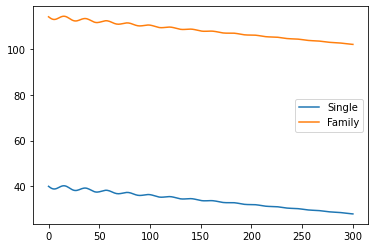

In [7]:
base_waste_df = pd.DataFrame()
base_waste_singel = []
base_waste_family = []
for i in range(301):
    single_household.calc_base_waste(i)
    base_waste_singel.append(single_household.base_waste)

    family_household.calc_base_waste(i)
    base_waste_family.append((family_household.base_waste))

base_waste_df['Single'] = base_waste_singel
base_waste_df['Family'] = base_waste_family

base_waste_df.plot()

The y-axis shows the base waste, the x-axis the ticks. The behaviour is as expected. <br>
The calculation of the plastic waste is the product of the base waste, the plastic share in
the base waste ($20\%$) and the individual knowledge and perception. Hence, the expected values are:

In [8]:
single_household.calc_base_waste(0)
print('Expected for value single household: {}'.format(single_household.base_waste * 0.2 * knowledge * perception))
single_household.calc_plastic_waste(0)
print('The result for single household is: {}'.format(single_household.plastic_waste))

Expected for value single household: 2.4
The result for single household is: 2.4


Since this function is the same for both household types, there is no added value in executing it for the multiple people
household. <br>Up to this point, all functions appear to work for in the class Household.



### 1.2 Municipality
Firstly, the municipality will be initialized and it will be checked whether the attributes were initialized correctly.

In [9]:
unique_id = 'M1'
model = None
population_distribution = [10, 20] # single households, family_households
initial_recycling_budget = 1000
recycling_target = 0.40
priority_price_over_recycling = 0.1



a_municipality = Municipality(unique_id, model, True, population_distribution, initial_recycling_budget,
                              recycling_target, priority_price_over_recycling)

print('ID: {}'.format(a_municipality.id))
print('Population distribution: {}'.format(a_municipality.population_distribution))
print('Initial recycling budget {}'.format(a_municipality.budget_plastic_recycling))
print('Recycling target: {}'.format(a_municipality.recycling_target))
print('Priority price over recycling {}'.format(a_municipality.priority_price_over_recycling))

ID: M1
Population distribution: [10, 20]
Initial recycling budget 1000
Recycling target: 0.4
Priority price over recycling 0.1


Besides those variables, other variables get initiated as an empty contract and specifications for policies.
Further, the Municipality class implements the households by itself. Whether those are initiated correctly is checked in the following.

In [10]:
print('Number of households present: {}'.format(len(a_municipality.households)))
print('Type of object in list: {}'.format(type(a_municipality.households[1])))

single_count = 0
multi_count = 0
for i in range(len(a_municipality.households)):
    if a_municipality.households[i].type == 'one_person':
        single_count +=1
    elif a_municipality.households[i].type == 'multi_person':
        multi_count += 1

print('Single person households: {}'.format(single_count))
print('Mulitple person househould: {}'.format(multi_count))

Number of households present: 30
Type of object in list: <class 'Household.Household'>
Single person households: 10
Mulitple person househould: 20


The households appear to be initiated correctly. The first function to be investigated is request_offer.
It is supposed to return a reference to the municipality (itself) if the municipality does not have
a company to treat their waste. Since no connection to a company was initiated, it should return itself.

In [11]:
a_municipality == a_municipality.request_offer(0)

True

If the municipality has an ongoing contract with a recycling company,
the attribute contract holds an entry ‘active = True’. The function request_offer is
supposed to return ‘None’ if the contract did not expire.

In [12]:
a_recycling_company = RecyclingCompany('R1', None)
a_municipality.contract['active'] = True
a_municipality.contract['recycling_company'] = a_recycling_company
a_municipality.contract['expiration_tick'] = 10

print(a_municipality.request_offer(9))

None


If the expiration tick (time at which the contract ends) is reached, the function supposed to return itself
 (the municipality) and to set the 'active' entry in the contract attribute to false.

In [13]:
print('Returns itself: {}'.format(a_municipality == a_municipality.request_offer(10)))
print('Contract status: {}'.format(a_municipality.contract['active']))

Returns itself: True
Contract status: False


The last function to be checked in this step is receive_funding. Other functions involve either other
agents or were used for internal testing. receive_funding adds a specific amount of money per household to
budget_plastic_recycling. The increase rate per household is set to 1. Since there are 30 households in a_municipality, the budget should increase by 30.


In [14]:
old_budget = a_municipality.budget_plastic_recycling
a_municipality.receive_funding(1)
new_budget = a_municipality.budget_plastic_recycling

print('Difference between old and new budget: {}'.format(new_budget - old_budget))

Difference between old and new budget: 30


### 1.3 Recycling company
Firstly, the recycling company is initialized and it is checked
 whether the initialization is correct.

In [15]:
unique_id = "R1"
model = None
initial_money = 100000
initial_efficiency = 0.5
price = 10
operational_cost = 100
investing_threshold = 0.8

a_recycling_company = RecyclingCompany(unique_id, model, initial_money, initial_efficiency, price,
                                       operational_cost, investing_threshold)

print('ID: {}'.format(a_recycling_company.unique_id))
print('Price: {}'.format(a_recycling_company.price))
print('Initial money: {}'.format(a_recycling_company.budget))
print('Initial efficiency: {}'.format(a_recycling_company.efficiency))
print('Operationa_cost: {}'.format(a_recycling_company.opex))
print('Investing_threshold: {}'.format(a_recycling_company.investing_threshold))

ID: R1
Price: 10
Initial money: 100000
Initial efficiency: 0.5
Operationa_cost: 100
Investing_threshold: 0.8


The only function which does not concern either other agents or the environment is the new_tech
function. Based on the budget, the investment threshold, and an element of randomness, the company will
invest in a new technology. Because of the element of randomness, the function needs
to be tested in a while loop. The investment will change the efficiency, the price, the budget,
the operational costs, and it will delete the used technology from the available technologies.


In [16]:
print('Before investing:')
print('Price: {}'.format(a_recycling_company.price))
print('Budget: {}'.format(a_recycling_company.budget))
print('Efficiency: {}'.format(a_recycling_company.efficiency))
print('Operational cost: {}'.format(a_recycling_company.opex))
print('Available technologies: {}'.format(a_recycling_company.all_tech))

start_efficiency = a_recycling_company.efficiency
while start_efficiency == a_recycling_company.efficiency:
    a_recycling_company.new_tech()

print('')
print('After investing:')
print('Price: {}'.format(a_recycling_company.price))
print('Budget: {}'.format(a_recycling_company.budget))
print('Efficiency: {}'.format(a_recycling_company.efficiency))
print('Operational cost: {}'.format(a_recycling_company.opex))
print('Available technologies: {}'.format(a_recycling_company.all_tech))

Before investing:
Price: 10
Budget: 100000
Efficiency: 0.5
Operational cost: 100
Available technologies: ((0.15, 0.15, 80000, 20), (0.06, 0.1, 50000, 15), (0.03, 0.08, 30000, 10))

After investing:
Price: 11.5
Budget: 20000
Efficiency: 0.65
Operational cost: 120
Available technologies: ((0.06, 0.1, 50000, 15), (0.03, 0.08, 30000, 10))


The new_tech function works as it is supposed to do.

## 2. Single-agent Testing
In this section, the single agents are tested using inputs at the end of their possible range.
This way the sanity of the agent implementation is supposed to be insured.
### 2.1 Household

The sanity of the in and outputs was proven to an extent in the previous section.
The household only receive
the tick as an external value. The only thing requiring further insurance is that
 the base waste does not go below 0 within the regarded timeframe which is two years (240 ticks).


In [17]:
single_household.calc_base_waste(240)
print('Single household basewaste at tick 240: {}'.format(single_household.base_waste))

Single household basewaste at tick 240: 30.37697366403319


### 2.2 Municipality
As for the households, there are few inputs which can be extreme or infeasible. Further, the sanity was sufficiently
proven in the previous section. In case the model should be applied to real size municipalities entailing
thousands of households, it might be interesting whether the implementation can handle this.

In [18]:
unique_id = 'M1'
model = None
population_distribution = [10000, 20000] # single households, family_households
initial_recycling_budget = 1000
recycling_target = 0.40
priority_price_over_recycling = 0.1



a_municipality = Municipality(unique_id, model, True, population_distribution, initial_recycling_budget,
                              recycling_target, priority_price_over_recycling)

single_count = 0
multi_count = 0
for i in range(len(a_municipality.households)):
    if a_municipality.households[i].type == 'one_person':
        single_count +=1
    elif a_municipality.households[i].type == 'multi_person':
        multi_count += 1

print('Single person households: {}'.format(single_count))
print('Mulitple person househould: {}'.format(multi_count))

Single person households: 10000
Mulitple person househould: 20000


Apparently, the class can handle large quantities of households.

### 2.3 Recycling company
The functions in the class recycling company which concern only the class itself perform sanely and cannot be put to the
extreme.

## 3. Interaction testing in minimal model

In order to check the interactions between the agents, a model with one municipality entailing one single household and one
multiple person household, and one recycling company is initialized. After this, each section of the model’s step
function is executed externally (by replacing self. with test_model.) and it will be checked whether required actions
were executed as expected.


In [19]:
# the following list represent
# [number_id, home_collection,
# population_distribution,
# budget_plastic_recycling,
# recycling_target,
# priority_price_over_recycling]

defined_municipalities = [[1, False, [1, 1], 1000, 0.65, 1]]

test_model = ABM_model(defined_municipalities, n_recycling_companies= 1, funding_municipalities= 50,
                  improving_tech_recycling_company= True)

print('Recycling companies: {}'.format(test_model.recycling_companies))
print('Municipalities: {}'.format(test_model.municipalities))
print('Households: {}'.format(test_model.households))


Recycling companies: [<RecyclingCompany.RecyclingCompany object at 0x000001FBB53E8220>]
Municipalities: [<Municipality.Municipality object at 0x000001FBB53E8280>]
Households: [<Household.Household object at 0x000001FBB53E8790>, <Household.Household object at 0x000001FBB53E87F0>]


The first chunk of the step supplies the municipality with its yearly funding, makes
the households produce waste, which is then accounted for by the total potential plastic waste
counter and the actual plastic waste counter.

In [20]:
import random
print('Before step chunk:')
print('Municipality budget: {}'.format(test_model.municipalities[0].budget_plastic_recycling))
print('The rest of the relevant variables are set to zero at the beginning of the chunk.')

# reset counters
test_model.total_potential_plastic_waste = 0
test_model.total_plastic_waste = 0
test_model.total_recycled_plastic = 0

# iterate in random order over municipalities to establish order
municipalities_index_list = list(range(len(test_model.municipalities)))
random.shuffle(municipalities_index_list)

# municipalities receive funding if it is the start of the year
if test_model.tick%12 == 0:
    for municipality in test_model.municipalities:
        municipality.receive_funding(test_model.funding_municipalities)

# households in municipalities produce waste
for municipality in test_model.municipalities:
    for household in municipality.households:
        household.calc_base_waste(test_model.tick)
        household.calc_plastic_waste(test_model.tick)

        # Add potential_plastic waste to total_potential_plastic waste
        test_model.total_potential_plastic_waste += household.potential_plastic_waste
        test_model.total_plastic_waste += household.plastic_waste
print('')
print('After step chunk:')
print('Municipality budget: {}'.format(test_model.municipalities[0].budget_plastic_recycling))
print('Total potential plastic waste: {}'.format(test_model.total_potential_plastic_waste))
print('Total collected plastic waste: {}'.format(test_model.total_plastic_waste))

Before step chunk:
Municipality budget: 100
The rest of the relevant variables are set to zero at the beginning of the chunk.

After step chunk:
Municipality budget: 200
Total potential plastic waste: 30.8
Total collected plastic waste: 7.7


The model and its agents behave as expected. The next code chunk of the step function is responsible for the contract closing between the
municipality and the company. Since it is the first step, the municipality needs to close a contract with a
recycling company.

In [21]:
print('Before step chunk:')
print('Contract of municipality')
print(test_model.municipalities[0].contract)
# contract closing
        # municipalities in need of a new recycling company announce it to the market by requesting an offer
for municipality_index in municipalities_index_list:
    offer = test_model.municipalities[municipality_index].request_offer(test_model.tick)

    if offer != None:
        test_model.offer_requests.append(offer)

# recycling companies send offers to municipalities
for recycling_company in test_model.recycling_companies:
    recycling_company.provide_offer(test_model.offer_requests)

# municipalities select an offer based on their behavior (select cheapest one for a given recycling rate)
for municipality in test_model.offer_requests:
    municipality.select_offer(test_model.tick)

# reset offers
test_model.offer_requests = []

print('')
print('After step chunk:')
print('Contract of municipality')
print(test_model.municipalities[0].contract)

Before step chunk:
Contract of municipality
{'active': False, 'recycling_company': None, 'recycling_rate': None, 'price': None, 'fee': None, 'expiration_tick': None, 'minimal_plastic_waste_mass': None}

After step chunk:
Contract of municipality
{'active': True, 'recycling_company': <RecyclingCompany.RecyclingCompany object at 0x000001FBB53E8220>, 'recycling_rate': 0.4, 'price': 10, 'fee': 2.0, 'expiration_tick': 23, 'minimal_plastic_waste_mass': 7.623, 'municipality': <Municipality.Municipality object at 0x000001FBB53E8280>}


The municipality finds the recycling company and closes a contract with it. In the following code chunk the
municipality collects the waste from the household and passes it to the recycling company.
It is then checked whether the municipality delivered a sufficient quantity of plastic waste and pays a
fee if not. The municipality pays for the waste, and the recycling company sells the plastic they
could recycle.

In [22]:
print('Before step chunk:')
print('Total recycled plastic: {}'.format(test_model.total_recycled_plastic))
print('Budget municipality: {}'.format(test_model.municipalities[0].budget_plastic_recycling))
print('Budget recycling company: {}'.format(test_model.recycling_companies[0].budget))

for municipality in test_model.municipalities:
        municipality.plastic_waste = 0
        for household in municipality.households:
            municipality.plastic_waste += household.plastic_waste
        # mass of plastic whichis recycled by the recycling company is calculated here
        municipality.recyclable = municipality.plastic_waste * municipality.contract['recycling_rate']

        # add mass mass of recycled plastic to total_recycled_plastic
        test_model.total_recycled_plastic += municipality.recyclable


# check contract conditions - has municipality delivered enough plastic waste, etc.?
for municipality in test_model.municipalities:
    # 1: municipality pays for waste processing
    municipality.budget_plastic_recycling -= municipality.contract['price'] * municipality.plastic_waste

    # 2: recycling company gets paid for waste processing
    municipality.contract['recycling_company'].budget += municipality.contract['price'] * municipality.plastic_waste
    municipality.contract['recycling_company'].budget -= municipality.contract['recycling_company'].opex

    # 3: recycling company gets paid fee, in case the municipality did not deliver enough waste
    if municipality.plastic_waste < municipality.contract['minimal_plastic_waste_mass']:
        # 3.1 the mass off the missing waste is calculated
        missing_waste = municipality.contract['minimal_plastic_waste_mass'] - municipality.plastic_waste

        # 3.2: municipality pays fee
        municipality.budget_plastic_recycling -= municipality.contract['fee'] * missing_waste

        # 3.3: recycling company gets paid the fee
        municipality.contract['recycling_company'].budget += municipality.contract['fee'] * missing_waste

        test_model.debug_count_fee += 1
        print('The municipality had to pay a fee')
    else:
        print('The municipality did not have to pay a fee')

    # 4: recycling company gets paid for sold recycled waste
    municipality.contract['recycling_company'].budget += (municipality.recyclable)*1.5 # 1.5 is the price per kg a company can sell

print('After step chunk:')
print('Total recycled plastic: {}'.format(test_model.total_recycled_plastic))
print('Budget municipality: {}'.format(test_model.municipalities[0].budget_plastic_recycling))
print('Budget recycling company: {}'.format(test_model.recycling_companies[0].budget))

Before step chunk:
Total recycled plastic: 0
Budget municipality: 200
Budget recycling company: 0
The municipality did not have to pay a fee
After step chunk:
Total recycled plastic: 3.08
Budget municipality: 123.0
Budget recycling company: -18.38


The model performs as expected. The budget of the recycling company is negative since the operating costs are too high to treat only the waste of two households.
The following code chunk performs the policy measures. To see how they work, all if statements except the first
one will be set to True.


In [23]:
print('Before step chunk:')
print('Knowledge of Household: {}'.format(test_model.households[0].knowledge))
print('Perception of Household: {}'.format(test_model.households[0].perception))

for municipality in test_model.municipalities:
    if test_model.tick != 0:
        municipality.do_outreach('stay')
    # Reverse collection
    if True:
        if True: # if tick equals tick to introduce the policy
            municipality.do_outreach('reverse_waste_collection')
    print('')
    print('After reverse colletion introduction')
    print('Knowledge of Household: {}'.format(test_model.households[0].knowledge))
    print('Perception of Household: {}'.format(test_model.households[0].perception))

    # Education
    if True:
        if True: # if education is supposed to happen in this step
            municipality.do_outreach('education')
    print('')
    print('After education')
    print('Knowledge of Household: {}'.format(test_model.households[0].knowledge))
    print('Perception of Household: {}'.format(test_model.households[0].perception))

    # Container labeling
    if True:
        if True: # if it is the step in which container labeling should be introduced
            municipality.do_outreach('container_labeling')
    print('')
    print('After container labeling')
    print('Knowledge of Household: {}'.format(test_model.households[0].knowledge))
    print('Perception of Household: {}'.format(test_model.households[0].perception))

Before step chunk:
Knowledge of Household: 0.5
Perception of Household: 0.5

After reverse colletion introduction
Knowledge of Household: 0.4
Perception of Household: 0.7

After education
Knowledge of Household: 0.5
Perception of Household: 0.7999999999999999

After container labeling
Knowledge of Household: 0.6
Perception of Household: 0.7999999999999999


Knowledge and perception change correctly. Reverse collection is supposed to decrease knowledge and to increase
perception. Education is supposed to increase both, and container labeling is supposed to only increase knowledge.
The last chunk of the step iterates over the recycling companies and calls new_tech(), so the
companies potentially invest in new technology. The functionality of this method was proven
above.


In [24]:
if test_model.improving_tech_recycling_company:
    for recycling_company in test_model.recycling_companies:
        recycling_company.new_tech()

It can be concluded, that agents find each other and that interactions create correct results.
Unidentified interactions could not be found. Looking at the inputs possible
in the single agent model, there are no potential extreme values to be tested.
The fact that recycling companies make a loss if they have only two households supplying
waste was a new finding though.


## 4. Multi-agent Testing
The basic functionality of the model has been proven by the previous points. The
most critical aspect which is not sufficiently covered by the tests above is
whether municipalities close new contracts with other recycling companies when
their contract expires. Proving this will serve as an exemplary investigation to be performed
 for multi-agent testing. To do so, a model with 10 municipalities and 5 recycling
companies is run for 240 steps. It will be checked, whether some municipalities
switched companies by looking at the matches after the first and the last step.

In [25]:
defined_municipalities = [[1, True, [54, 54], 96,  0.5, 1],
                          [2, False, [32, 24], 123, 0.6, 0.1],
                          [3, False, [7, 14], 126, 0.6, 0.2],
                          [4, True, [60, 30], 107, 0.7, 0.5],
                          [5, True, [10, 1], 136, 0.6, 0.2],
                          [6, False, [64, 32], 109, 0.4, 0.7],
                          [7, False, [39, 39], 96, 0.7, 0.3],
                          [8, True, [14, 21], 70, 0.5, 0.6],
                          [9, False, [36, 27], 106, 0.5, 0.5],
                          [10, True, [21, 21], 120, 0.6, 0.4]]

test_model_2 = ABM_model(defined_municipalities, n_recycling_companies= 5, funding_municipalities= 50,
                  improving_tech_recycling_company= True)

# doing fist step
test_model_2.step()

print('ID of matched recycling company in the beginning:')
print([municipality.contract['recycling_company'].id for municipality in test_model_2.municipalities])

recycling_company_matches_start = [municipality.contract['recycling_company'] for municipality in test_model_2.municipalities]

# doing 239 steps
for i in range(239):
    test_model_2.step()

recycling_company_matches_end = [municipality.contract['recycling_company'] for municipality in test_model_2.municipalities]

equal_to_start = [start == end for start, end in zip(recycling_company_matches_start, recycling_company_matches_end)]

print('')
print('ID of matched recycling company in the end:')
print([municipality.contract['recycling_company'].id for municipality in test_model_2.municipalities])
print('')
print('Vector showing whether the recycling company stayed the same for each municipality:')
print(equal_to_start)

ID of matched recycling company in the beginning:
['R_3', 'R_0', 'R_4', 'R_1', 'R_1', 'R_4', 'R_3', 'R_1', 'R_3', 'R_2']

ID of matched recycling company in the end:
['R_4', 'R_1', 'R_4', 'R_3', 'R_4', 'R_1', 'R_2', 'R_3', 'R_2', 'R_0']

Vector showing whether the recycling company stayed the same for each municipality:
[False, False, True, False, False, False, False, False, False, False]


As one can see, some municipalities switched recycling companies and some did not (it is also possible that
they switched and switched back). Hence, it is concluded that the mechanism to close and end contracts
between municipalities and recycling companies is working correctly. <br>
Another verification method within the multi-agent testing is to conduct variability tests. This is done
extensively in the sensitivity analysis which therefore supplements this verification.
